In [1]:
import re
from wxpy import *
import jieba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns
from scipy.misc import imread
from wordcloud import WordCloud, ImageColorGenerator
import gmplot
from matplotlib.patches import Polygon
from matplotlib.colors import rgb2hex

%matplotlib inline

In [2]:
# 初始化机器人，扫码登录
bot = Bot()

# 获取所有好友
my_friends = bot.friends()
print(type(my_friends))

Getting uuid of QR code.
Please scan the QR code to log in.
Please press confirm on your phone.
Loading the contact, this may take a little while.
Login successfully as 范梅


<class 'wxpy.api.chats.chats.Chats'>


LOG OUT!


In [3]:
my_friends[0].raw

{'Alias': '',
 'AppAccountFlag': 0,
 'AttrStatus': 4294053,
 'ChatRoomId': 0,
 'City': '厦门',
 'ContactFlag': 5,
 'DisplayName': '',
 'EncryChatRoomId': '',
 'HeadImgFlag': 1,
 'HeadImgUrl': '/cgi-bin/mmwebwx-bin/webwxgeticon?seq=678111631&username=@822de03645977134b5a4510bb00ba1dc&skey=@crypt_15eb1cad_e74d89db939f1fd05c81f31126d06056',
 'HideInputBarFlag': 0,
 'IsOwner': 0,
 'KeyWord': 'fan',
 'MemberCount': 0,
 'MemberList': [],
 'NickName': '范梅',
 'OwnerUin': 0,
 'PYInitial': 'FM',
 'PYQuanPin': 'fanmei',
 'Province': '福建',
 'RemarkName': '',
 'RemarkPYInitial': '',
 'RemarkPYQuanPin': '',
 'Sex': 2,
 'Signature': '嬉皮笑脸地面对人生的难',
 'SnsFlag': 49,
 'StarFriend': 0,
 'Statues': 0,
 'Uin': 1039718600,
 'UniFriend': 0,
 'UserName': '@822de03645977134b5a4510bb00ba1dc',
 'VerifyFlag': 0,
 'WebWxPluginSwitch': 0}

In [4]:
sec_dict = {'male':0,'female':0,'other':0}

# 统计性别
for friend in my_friends:
    if friend.sex == 1:
        sec_dict['male'] += 1
    elif friend.sex == 2:
        sec_dict['female'] += 1
    else:
        sec_dict['other'] += 1

print(sec_dict)

{'male': 189, 'female': 127, 'other': 16}


In [5]:
# convert dictionary into DataFrame
df_sex = pd.DataFrame(list(sec_dict.items()),columns=['sex','count'])
df_sex

,sex,count
0,male,189
1,female,127
2,other,16


In [6]:
total = df_sex['count'].sum()
print(total)

df_sex['pct'] = df_sex['count']/total
df_sex

332


,sex,count,pct
0,male,189,0.569277
1,female,127,0.382530
2,other,16,0.048193


In [7]:
# count the numbers of sexes and convert it into DataFrame

def find_out_sex(raw):
    sex_dict = {'male':0,'female':0,'other':0}
    for friend in my_friends:
        if friend.sex == 1:
            sex_dict['male'] += 1
        elif friend.sex == 2:
            sex_dict['female'] += 1
        else:
            sex_dict['other'] += 1
    
    df_sex = pd.DataFrame(list(sex_dict.items()),columns=['sex','count'])
    total = df_sex['count'].sum()
    df_sex['pct'] = df_sex['count']/total
    
    return sex_dict, df_sex

# find_out_sex(my_friends)

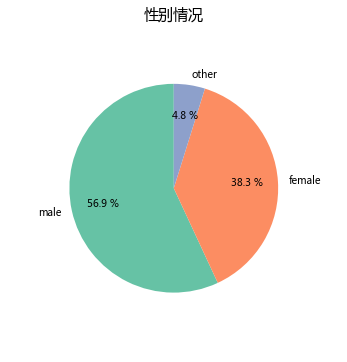

In [8]:
# draw pie charts
sns.set_palette('Set2')

fig = plt.figure(figsize=(12,6))

labels = df_sex.sex  #use the sex as lables
plt.axes(aspect=1)  # set this to make a round figure

plt.title("性别情况",fontdict={'fontsize':15},loc='center')  

plt.pie(data=df_sex, x=df_sex['pct'], labels=labels, autopct='%3.1f %%', radius=0.8,
        labeldistance=1.1, startangle = 90, pctdistance = 0.7)
plt.show()
# fig.savefig('friendsex.png', dpi=fig.dpi);

In [9]:
cities = []
for friend in my_friends:
    if friend.city not in cities:
        cities.extend([friend.city])

cities_dict= {}
for i in cities:
    cities_dict[i] = 0

for friend in my_friends:
    cities_dict[friend.city] += 1

df_city = pd.DataFrame(list(cities_dict.items()),columns=['city','count'])
df_city['city'] = df_city['city'].apply(lambda x: 'Others' if x=='' else x)

df_city_unique = df_city.groupby('city').sum()
df_city_unique = df_city_unique.reset_index()
df_city_unique['count'].sum()


332

In [10]:
# pull location data into DataFrame

def obtain_city_data(raw):
    # create cities list to store unique city names
    cities = []
    for friend in my_friends:
        if friend.city not in cities:
            cities.extend([friend.city])
    
    # create a city dictionary for number count
    cities_dict= {}
    for i in cities:
        cities_dict[i] = 0
    
    # pull the numbers out into the city dictionary
    for friend in my_friends:
        cities_dict[friend.city] += 1
    
    # convert the dictionary data into DataFrame
    df_city = pd.DataFrame(list(cities_dict.items()),columns=['city','count'])
    df_city['city'] = df_city['city'].apply(lambda x: 'Others' if x=='' else x)
    
    # groupby column city in case there's duplicate city items.
    df_city_unique = df_city.groupby('city').sum()
    #print(df_city_unique['count'].sum())   #check the total number
    df_city_unique = df_city_unique.reset_index()  # make sure the data is still in DataFrame
    
    return df_city_unique

#obtain_city_data(my_friends)    

In [11]:
city_lt = pd.read_csv('/Users/mabelfan/Documents/supports/城市经纬度.csv')
city_lt_copy = city_lt.copy()


In [12]:
df_city_lt = df_city_unique.merge(city_lt_copy, how='left',\
                                  left_on = 'city', right_on ='city')

# delete the rows that still don't have lat and log information
df_city_lt_nonna = df_city_lt.dropna()

print(df_city_lt['count'].sum(),'\n',df_city_lt_nonna['count'].sum())
#df_city_lt_nonna

332 
 249


In [13]:
# search the lat/log info for the cities not included in original data and convert it to DataFrame
# city_lt = {'经度':[106.429500,34.030000,121.500000,100.230000,121.250000,116.300000,121.470000,116.370000,116.420000,121.270000],\
#           '纬度':[29.833700,118.150000,25.050000,25.600000,25.030000,39.950000,31.230000,39.920000,39.930000,31.380000],\
#          'city':['北碚','Los Angeles','台北市','大理','桃园县','海淀','黄浦','西城','东城','嘉定']}
# df_city_add = pd.DataFrame(city_lt)

# delete the last word '市' to better concat
#city_lt_copy['city'] = city_lt_copy['地级以上城市'].apply(lambda x: x[:-1] if x[-1] == '市' else x)

#concat the added lat/log info with the orignal one and save it locally
#city_lt =  pd.concat([city_lt_copy, df_city_add], ignore_index=True)
#city_lt.to_csv('../城市经纬度.csv',index=False)  # attention to not keep the index column

In [14]:
latitude = list(df_city_lt_nonna['纬度'])
longitude = list(df_city_lt_nonna['经度'])

# Place map
gmap = gmplot.GoogleMapPlotter(latitude[0],longitude[0], 16)

# personal moving line
latitude1=[27.795574,29.833700,22.556396,24.457436,27.795574]
longitude1=[114.374611,106.429500,114.110672,118.087517,114.374611]
gmap.plot(latitude1, longitude1, 'cornflowerblue', edge_width=10)

# Marker
hidden_gem_lat, hidden_gem_lon = 118.101897,24.576368
gmap.marker(hidden_gem_lat, hidden_gem_lon, 'cornflowerblue')

gmap.draw("my_loc_map.html")

#gmap.scatter(latitude, longitude, '#3B0B39', size=40, marker=False)
#gmap.draw("mymap1.html")   

#gmap.scatter(latitude, longitude, 'k', marker=True)
#gmap.draw("mymap2.html")

#gmap.heatmap(latitude, longitude)
#gmap.draw("mymap3.html")



# Write the map in an HTML file
#gmap.draw("mymap.html")

In [37]:
df_city_lt_nonna

,city,count,纬度,经度
2,Los Angeles,1,118.150000,34.030000
5,三明,2,26.223013,117.601227
6,东城,1,39.930000,116.420000
7,东莞,2,23.048536,113.748772
8,丽水,1,28.448837,119.916557
9,九江,1,29.723211,115.984581
10,佛山,1,23.034878,113.114517
11,内江,1,29.577568,105.053436
12,北碚,5,29.833700,106.429500
14,南京,1,32.047615,118.772781


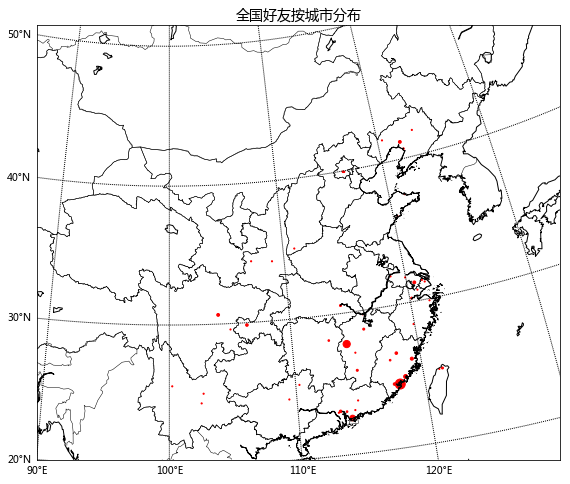

In [31]:

fig = plt.figure(figsize=(12,8))

lat = np.array(df_city_lt_nonna['纬度'])                        # 获取维度之维度值
lon = np.array(df_city_lt_nonna['经度'])                        # 获取经度值
pop = np.array(df_city_lt_nonna['count'],dtype=float)    # 获取人口数，转化为numpy浮点型

size=(pop/np.max(pop))*100    # 绘制散点图时图形的大小，如果之前pop不转换为浮点型会没有大小不一的效果

map = Basemap(llcrnrlon=90, llcrnrlat=20, urcrnrlon=140,urcrnrlat=45,\
              projection='stere', lat_0=35, lon_0=100, resolution='l')

map.drawcoastlines()   
map.drawcountries()    

map.readshapefile('gadm36_CHN_shp/gadm36_CHN_1', 'states', drawbounds=True)
map.readshapefile('gadm36_CHN_shp/gadm36_CHN_2', 'cities', drawbounds=False)
map.readshapefile('gadm36_TWN_shp/gadm36_TWN_2', 'taiwan2', drawbounds=False)
#map.drawmapboundary()

parallels = np.arange(0.,90,10.) 
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10) # 绘制纬线

meridians = np.arange(80.,140.,10.)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10) # 绘制经线

# compute map projection coordinates for lat/lon grid.
x,y = map(lon,lat)

# map.scatter(x,y,edgecolors='r',facecolors='r',marker='*',s=320)

map.scatter(x,y,edgecolors='r',facecolors='r',marker='o',s=size)

plt.title('全国好友按城市分布',fontdict={'fontsize':14},loc='center')

plt.show()


In [43]:
import folium
from folium.plugins import HeatMap

lat = np.array(df_city_lt_nonna['纬度'])                        # 获取维度之维度值
lon = np.array(df_city_lt_nonna['经度'])                        # 获取经度值
pop = np.array(df_city_lt_nonna['count'],dtype=float)          # 获取人口数，转化为numpy浮点型

num = len(df_city_lt_nonna)

data1 = [[lat[i],lon[i],pop[i]] for i in range(num)]    #将数据制作成[lats,lons,weights]的形式

map_osm = folium.Map(location=[32,110],zoom_start=5,control_scale=True)    #绘制Map，开始缩放程度是5倍
HeatMap(data1).add_to(map_osm)  # 将热力图添加到前面建立的map里
#为m添加标记部件
folium.Marker([24.457436,118.087517],popup='Mt. Hood Meadows',
              icon=folium.Icon(icon='cloud')).add_to(map_osm)

ls = folium.PolyLine(locations=[[27.795574,114.374611],[29.833700,106.429500],\
                                [22.556396,114.110672],[24.457436,118.087517]],color='blue')

ls.add_to(map_osm)

map_osm
#map_osm.save('friend_dist.html')     # 保存为html文件

In [14]:
provinces = []
for friend in my_friends:
    if friend.province not in provinces:
        provinces.extend([friend.province])

provinces = [x for x in provinces if len(x)>0]

pro_dict = {}
for i in provinces:
    pro_dict[i] = 0
#pro_dict

In [15]:
for friend in my_friends:
    if friend.province in pro_dict.keys():
        pro_dict[friend.province] += 1

df_pro = pd.DataFrame(list(pro_dict.items()), columns=['province','count'])

df_pro['count'].sum()

500

In [16]:
df_pop = df_pro.copy()
df_pop['省名'] = df_pop['province'].apply([lambda x: x.replace(" ","")])
df_pop.set_index('省名', inplace=True)
#df_pop

In [17]:
def get_pro(info):
    pro = info.split('|')
    if len(pro) > 1:
        s = pro[1]
    else:
        s = pro[0]
    s = s[:2]
    if s == '黑龍':
        s = '黑龙江'
    if s == '内蒙':
        s = '内蒙古'
    return s

In [18]:
from langconv import *

def Traditional2Simplified(sentence):
    '''
    将sentence中的繁体字转为简体字
    :param sentence: 待转换的句子
    :return: 将句子中繁体字转换为简体字之后的句子
    '''
    return Converter('zh-hans').convert(sentence)
    

In [19]:
def draw_city():
    fig = plt.figure(figsize=(16,9))

    # only show China map
    m = Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
                projection='lcc', lat_1=33, lat_2=45, lon_0=100)

    # readshapefile, make sure which file you want to read in the gadm36_CHN_shp folder
    m.readshapefile('gadm36_CHN_shp/gadm36_CHN_2', 'cities', drawbounds=True)

    m.readshapefile('gadm36_TWN_shp/gadm36_TWN_2', 'taiwan2', drawbounds=True)

    ax = plt.gca()
    for info, shp in zip(m.cities_info, m.cities):
        city = info['NL_NAME_2']
        poly = Polygon(shp,edgecolor='c')
        ax.add_patch(poly)
    
    for info, shp in zip(m.taiwan2_info, m.taiwan2):
        city = info['NL_NAME_2']
        poly = Polygon(shp,edgecolor='c')
        ax.add_patch(poly)
    
    plt.show()

#draw_city()

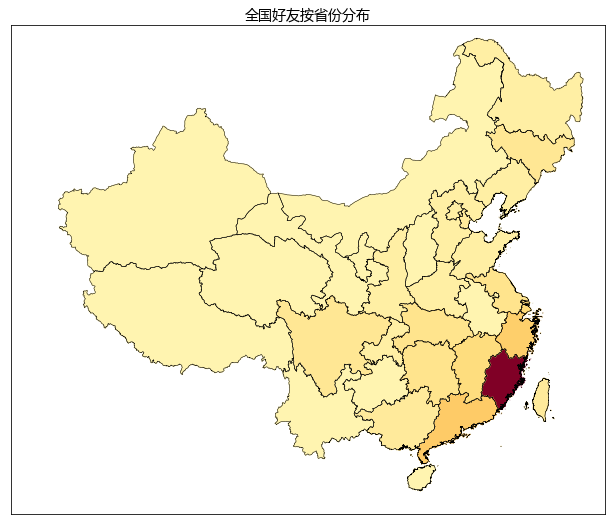

In [21]:
fig = plt.figure(figsize=(16,9))

#m = Basemap()

# only show China map
m = Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
            projection='lcc', lat_1=33, lat_2=45, lon_0=100)

# readshapefile, make sure which file you want to read in the gadm36_CHN_shp folder
m.readshapefile('gadm36_CHN_shp/gadm36_CHN_1', 'states', drawbounds=True)

m.readshapefile('gadm36_TWN_shp/gadm36_TWN_0', 'taiwan', drawbounds=True)

# draw coast lines
#m.drawcoastlines()

# draw country lines
#m.drawcountries(linewidth=1.5)

#ax = plt.gca()
#for nshape, seg in enumerate(m.states):
#    poly = Polygon(seg, facecolor='r')
#    ax.add_patch(poly)

cmap = plt.cm.YlOrRd
vmax = 1500
vmin = -10

ax = plt.gca()
for info, shp in zip(m.states_info, m.states):
    state = info['NL_NAME_1']
    proid = get_pro(state)
    if proid not in df_pop['province']:
        pop = 0
    else:
        pop = df_pop['count'][proid]*10
    color = rgb2hex(cmap(np.sqrt((pop - vmin) / (vmax - vmin)))[:3])
    poly = Polygon(shp,facecolor=color,edgecolor=color)
    ax.add_patch(poly)

for nshape, shp in enumerate(m.taiwan):
    pop = df_pop['count']['台湾']*10
    color = rgb2hex(cmap(np.sqrt((pop - vmin) / (vmax - vmin)))[:3])
    poly = Polygon(shp,facecolor=color,edgecolor=color)
    ax.add_patch(poly)

plt.title('全国好友按省份分布',fontdict={'fontsize':14},loc='center')
    
plt.show();

In [22]:
#提取好友签名，并去掉span，class，emoji，emoji1f3c3等的字段
signatures = []
for i in my_friends[1:]:
    signature = i.signature.strip().replace("span", "").replace("class", "").replace("emoji", "")
# 正则匹配过滤掉emoji表情，例如emoji1f3c3等
    reg1 = re.compile("1f\d.+")
    reg2 = re.compile('\s*') #匹配占位符
    signature = reg2.sub("", reg1.sub("", signature))
    if len(signature) > 0:
        signatures.append(signature)

# 拼接字符串
text = "".join(signatures)

In [26]:
# jieba分词

stopwords = {}.fromkeys([line.rstrip() for line in open('../stopwords.txt','r')])
wordlist_jieba = jieba.cut(text, cut_all=False)

#wl_space_split = " ".join(wordlist_jieba)

final = ''
for word in wordlist_jieba:
    if word not in stopwords:
        final += word
        final += " "

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/yz/qcyb2b3n46j6_vlgcyy_n67w0000gn/T/jieba.cache
Loading model cost 1.055 seconds.
Prefix dict has been built succesfully.


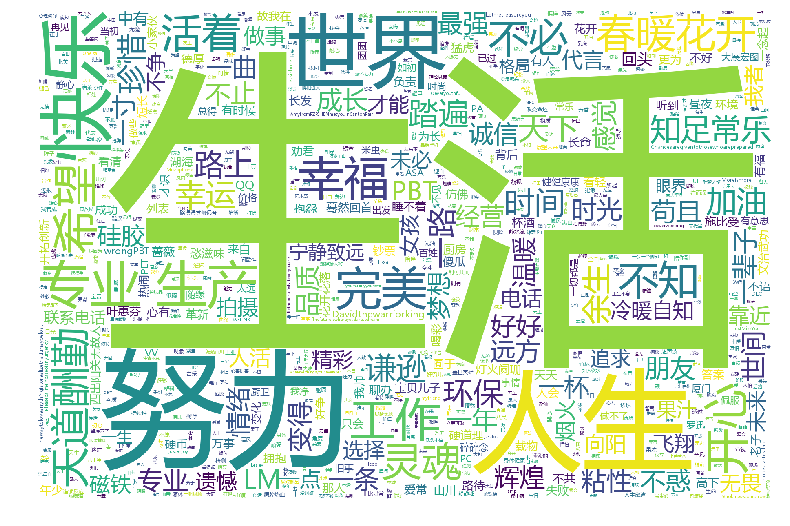

In [27]:
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] 

# Generate a word cloud image
font = r'/Library/Fonts/msyh.ttf'
wordcloud = WordCloud(background_color="white",font_path=font, 
                        width=1800, height=1200,max_words=2000, max_font_size=800,).generate(final)
fig = plt.figure(figsize=(16,9))

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# fig.savefig('friendwords.png', dpi=fig.dpi)